In [1]:
%pip install matplotlib numpy scipy spectral rich scikit-learn scikit-image

Note: you may need to restart the kernel to use updated packages.


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn
import sklearn.cluster
import spectral as spy
from rich import print
import os

# Purpose:

I'll aim to distinguish between western honey bees (*Apis mellifera*) and the *Varroa destructor* parasitic mite (Varroa mite) using hyperspectral imaging. Hyperspectral images capture a broad spectrum of radiation from each pixel, enabling this differentiation.

The dataset is available [here](https://www.kaggle.com/datasets/imonbilk/bee-dataset-but-hs).

In [3]:
experiment_dir = "MitesOnBess_Sparse"
image_id = "055"

path = os.path.join("/", os.getcwd(), "BeeDataset_BUT_HS", experiment_dir, "capture", f"{image_id}.hdr")
path

'/home/kapi/Programming/Hyperspectral/BeeDataset_BUT_HS/MitesOnBess_Sparse/capture/055.hdr'

In [4]:
img = spy.open_image(path)
hyperspectral_img = img.load()
mean_image = np.mean(hyperspectral_img, axis=2)
rgb_image = spy.get_rgb(hyperspectral_img)

print(f"Hyperspectral image shape: {img.shape}")
print(f"Mean image shape: {mean_image.shape}")
print(f"RGB image shape: {rgb_image.shape}")

Hyperspectral image shape: (512, 512, 204)

Mean image shape: (512, 512)

RGB image shape: (512, 512, 3)

## Approach 1.

### K-means Clustering

We will begin with one of the simplest unsupervised learning algorithms: **k-means clustering**. The goal is to determine which **cluster** each pixel belongs to, enabling us to distinguish between bees and parasites. 

In [5]:
# from (row, col, band) to (row x col, band)
pixels = hyperspectral_img.reshape(-1, hyperspectral_img.shape[-1])
# normalize the pixels
pixels = pixels / np.max(pixels, axis=1, keepdims=True)

print(f"Pixels shape: {pixels.shape}")

n_clusters = 3
kmeans = sklearn.cluster.KMeans(n_clusters)
kmeans.fit(pixels)

Pixels shape: (262144, 204)

KMeans(n_clusters=3)

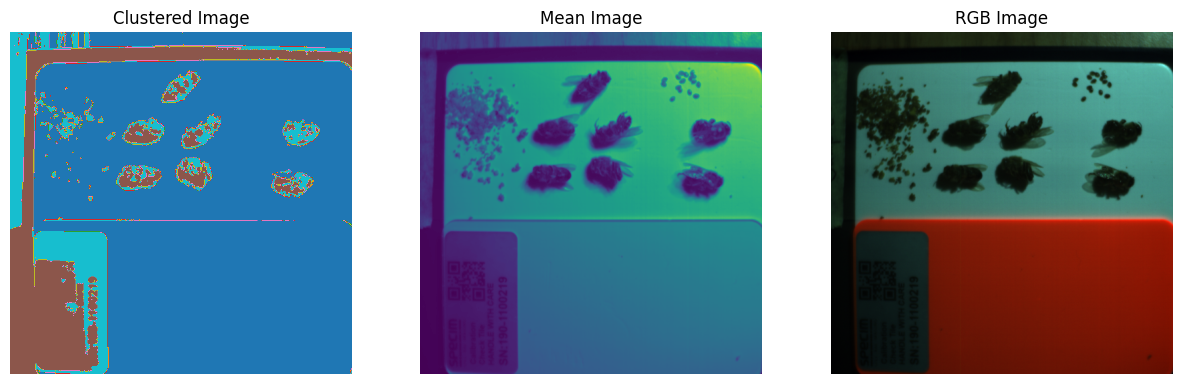

In [6]:
labeled_image = kmeans.labels_.reshape(hyperspectral_img.shape[:2])

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(labeled_image, cmap="tab10")
ax[0].set_title("Clustered Image")
ax[0].axis("off")
ax[1].imshow(mean_image)
ax[1].set_title("Mean Image")
ax[1].axis("off")
ax[2].imshow(rgb_image)
ax[2].set_title("RGB Image")
ax[2].axis("off")
plt.show()

The algorithm performed quite well overall. However, the shadows in the image posed a significant challenge. These likely disrupted the lighting and altered the radiation spectrum, leading to noticeable distortions around the edges of each segment. Potential solutions include splitting the image into smaller batches for processing or removing background noise to minimise interference.

It's important to note that this process is inherently random and may yield different results on each run. A cleaner, less noisy image would likely produce more consistent outcomes.

Additionally, this approach relies solely on spectral analysis. A more robust method would combine both spatial and spectral analysis to improve segmentation accuracy.

## Approach 2

In [80]:
from sklearn.preprocessing import StandardScaler

def preprocess_image():
    scaler = StandardScaler()

    # from (row, col, band) to (row x col, band)
    pixels = hyperspectral_img.reshape(-1, hyperspectral_img.shape[-1])
    # normalize the pixels
    pixels = pixels / np.max(pixels, axis=1, keepdims=True)

    pixels_scaled = scaler.fit_transform(pixels)
    pixels_scaled = pixels_scaled.reshape(hyperspectral_img.shape)

    return pixels_scaled

In [85]:
from skimage.segmentation import slic, mark_boundaries

def segmentize_image(n_segments, compactness=10, sigma=1, visualize=True):
    segments = slic(rgb_image, n_segments=n_segments, compactness=compactness, sigma=sigma)
    
    # visualization
    if not visualize:
        return segments
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(mark_boundaries(rgb_image, segments), cmap="tab10")
    ax[0].set_title("SLIC Segments")
    ax[0].axis("off")
    ax[1].imshow(rgb_image)
    ax[1].set_title("RGB Image")
    ax[1].axis("off")

    plt.show()

    return segments

In [104]:
def fit_and_show(pixels_scaled, segments, n_clusters):
    unique_segments = np.unique(segments)
    n_segments = len(unique_segments)

    print(f"Number of segments: {n_segments}")
    features = []
    

    for segment in unique_segments:
        segment_mask = segments == segment
        # 2D array. Each row is a pixel in the segment
        segment_pixels = pixels_scaled[segment_mask]

        # segment's high order statistics
        mean_spectrum = np.mean(segment_pixels, axis=0)
        std_spectrum = np.std(segment_pixels, axis=0)

        combined_features = np.concatenate([mean_spectrum, std_spectrum])
        features.append(combined_features)

    features = np.array(features)
    features.shape # (n_segments, n_bands * 2)

    kmeans = sklearn.cluster.KMeans(n_clusters)
    kmeans.fit(features)

    labeled_image = np.zeros_like(segments)
    for i, segment in enumerate(unique_segments):
        segment_mask = segments == segment
        labeled_image[segment_mask] = kmeans.labels_[i]

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    ax[0].imshow(labeled_image, cmap="tab10")
    ax[0].set_title("Clustered Image")
    ax[0].axis("off")
    ax[1].imshow(mark_boundaries(rgb_image, segments), cmap="tab10")
    ax[1].set_title("SLIC Segments")
    ax[1].axis("off")
    ax[2].imshow(rgb_image)
    ax[2].set_title("RGB Image")
    ax[2].axis("off")

    plt.show()

In [105]:
def approach2(n_clusters, n_segments):
    pixels_scaled = preprocess_image()
    segments = segmentize_image(n_segments, visualize=False)
    fit_and_show(pixels_scaled, segments, n_clusters)


Number of segments: 3844

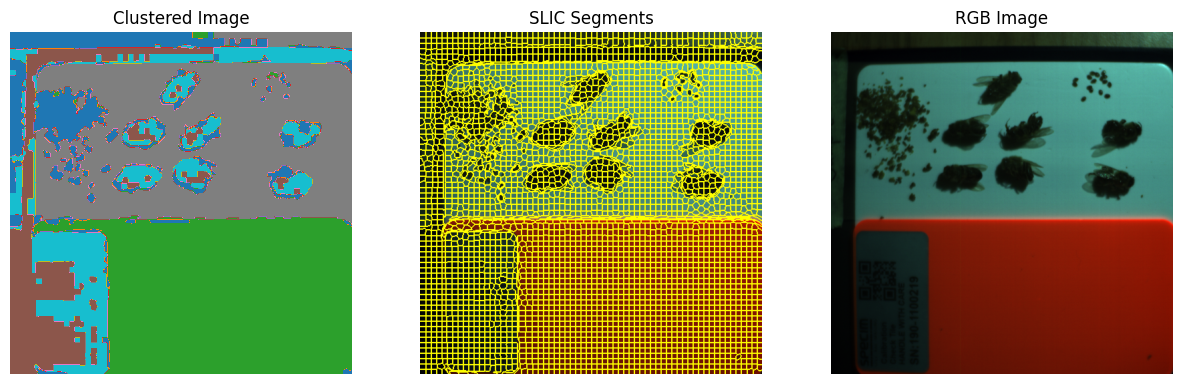

In [106]:
approach2(5, 4000)

We can see that more detailed segmentation (more segments) can extract small and packed parasites. However it does very poorly on bigger objects like bees. 

Number of segments: 156

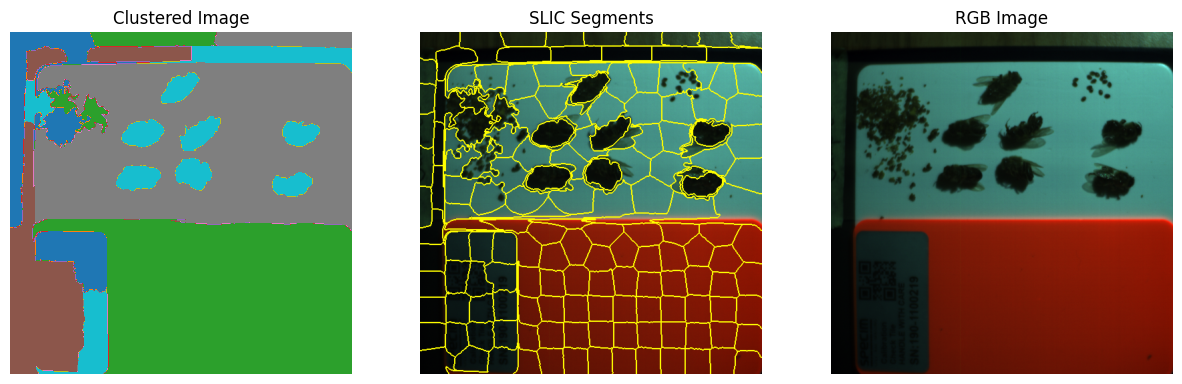

In [107]:
approach2(5, 200)

Lesser number of segments can classify bees pretty well. However it's unable to capture most spreaded out small objects as mites. 

Number of segments: 897

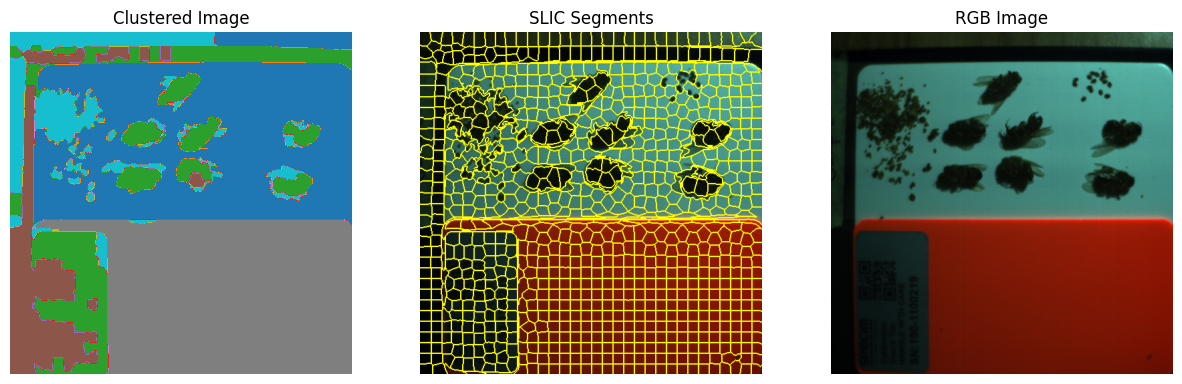

In [108]:
approach2(5, 1000)

It will be tough to find a reliable middleground for this task. We should look for another approaches.